# Warning :
# Do "File -> Save a copy in Drive" before you start modifying the notebook, otherwise your modifications will not be saved.


In [1]:
import argparse
import os
import time

import PIL
from PIL import Image

import numpy as np
import torchvision
import pickle

import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.utils.data
import torchvision.datasets as datasets
import torchvision.models as models
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torch.autograd import Variable

from sklearn.svm import LinearSVC

# Partie 1 : Architecture VGG16

In [2]:
#!wget https://github.com/cdancette/deep-learning-polytech-tp6-7/raw/master/tp8/imagenet_classes.pkl
!wget https://github.com/rdfia/rdfia.github.io/raw/master/data/3-a/imagenet_classes.pkl

# Bonus : Classifiez des exemples avec vgg16 et commentez le résultat dans votre rapport.
!wget --content-disposition https://unsplash.com/photos/gKXKBY-C-Dk/download?force=true -O cat.jpg
!wget --content-disposition https://unsplash.com/photos/qO-PIF84Vxg/download?force=true -O dog.jpg

--2024-11-19 15:31:18--  https://github.com/rdfia/rdfia.github.io/raw/master/data/3-a/imagenet_classes.pkl
Résolution de proxy.ufr-info-p6.jussieu.fr (proxy.ufr-info-p6.jussieu.fr)… 132.227.118.143, 132.227.118.144
Connexion à proxy.ufr-info-p6.jussieu.fr (proxy.ufr-info-p6.jussieu.fr)|132.227.118.143|:3128… connecté.
requête Proxy transmise, en attente de la réponse… 302 Found
Emplacement : https://raw.githubusercontent.com/rdfia/rdfia.github.io/master/data/3-a/imagenet_classes.pkl [suivant]
--2024-11-19 15:31:18--  https://raw.githubusercontent.com/rdfia/rdfia.github.io/master/data/3-a/imagenet_classes.pkl
Connexion à proxy.ufr-info-p6.jussieu.fr (proxy.ufr-info-p6.jussieu.fr)|132.227.118.143|:3128… connecté.
requête Proxy transmise, en attente de la réponse… 200 OK
Taille : 35454 (35K) [text/plain]
Sauvegarde en : « imagenet_classes.pkl.1 »

imagenet_classes.pk 100%[===================>]  34,62K  --.-KB/s    ds 0,001s  

2024-11-19 15:31:19 (35,4 MB/s) — « imagenet_classes.pkl.1 » s

In [3]:
a = torch.tensor([1,2,3])
a = a.view(3,1,1)
print(a)


tensor([[[1]],

        [[2]],

        [[3]]])


torch.Size([3, 224, 224])


/Vrac/Hatem/RDFIA/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Vrac/Hatem/RDFIA/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


C'est une image de Egyptian cat


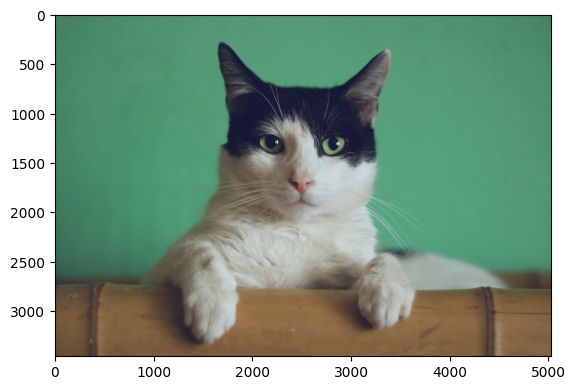

In [4]:
nameim = "cat"+".jpg"
#cat = Image.open('cat.jpg')
img = Image.open(nameim)
plt.imshow(img)

# Loading ImageNet classes
imagenet_classes = pickle.load(open('imagenet_classes.pkl', 'rb'))

# Normalization
img = img.resize((224, 224), Image.BILINEAR)
img = np.array(img, dtype=np.float32) / 255
img = img.transpose((2, 0, 1))
# ImageNet mean/std
mu = torch.Tensor([0.485, 0.456, 0.406])
sigma = torch.Tensor([0.229, 0.224, 0.225])
# Expand mu & sigma to match image size
# YOUR CODE HERE
img = torch.Tensor(img)
print(img.size())
mu = mu.view(3,1,1)
sigma = sigma.view(3,1,1)

# compute the normalized image with mean ImageNet image
# img = YOUR CODE HERE
img = (img-mu)/sigma

# Loding pre-trained VGG
vgg16 = torchvision.models.vgg16(pretrained=True)
vgg16.eval() # WHY THAT ?

# Forward pass on VGG
img = np.expand_dims(img, 0)
x = torch.Tensor(img)
y = vgg16(x) # TODO calcul forward
y = y.detach().numpy() # transformation en array numpy

# Get prediction (i.e., ImageNet class label)
# YOUR CODE HERE
predicted_class = imagenet_classes[y.argmax()]
print("C'est une image de", predicted_class)

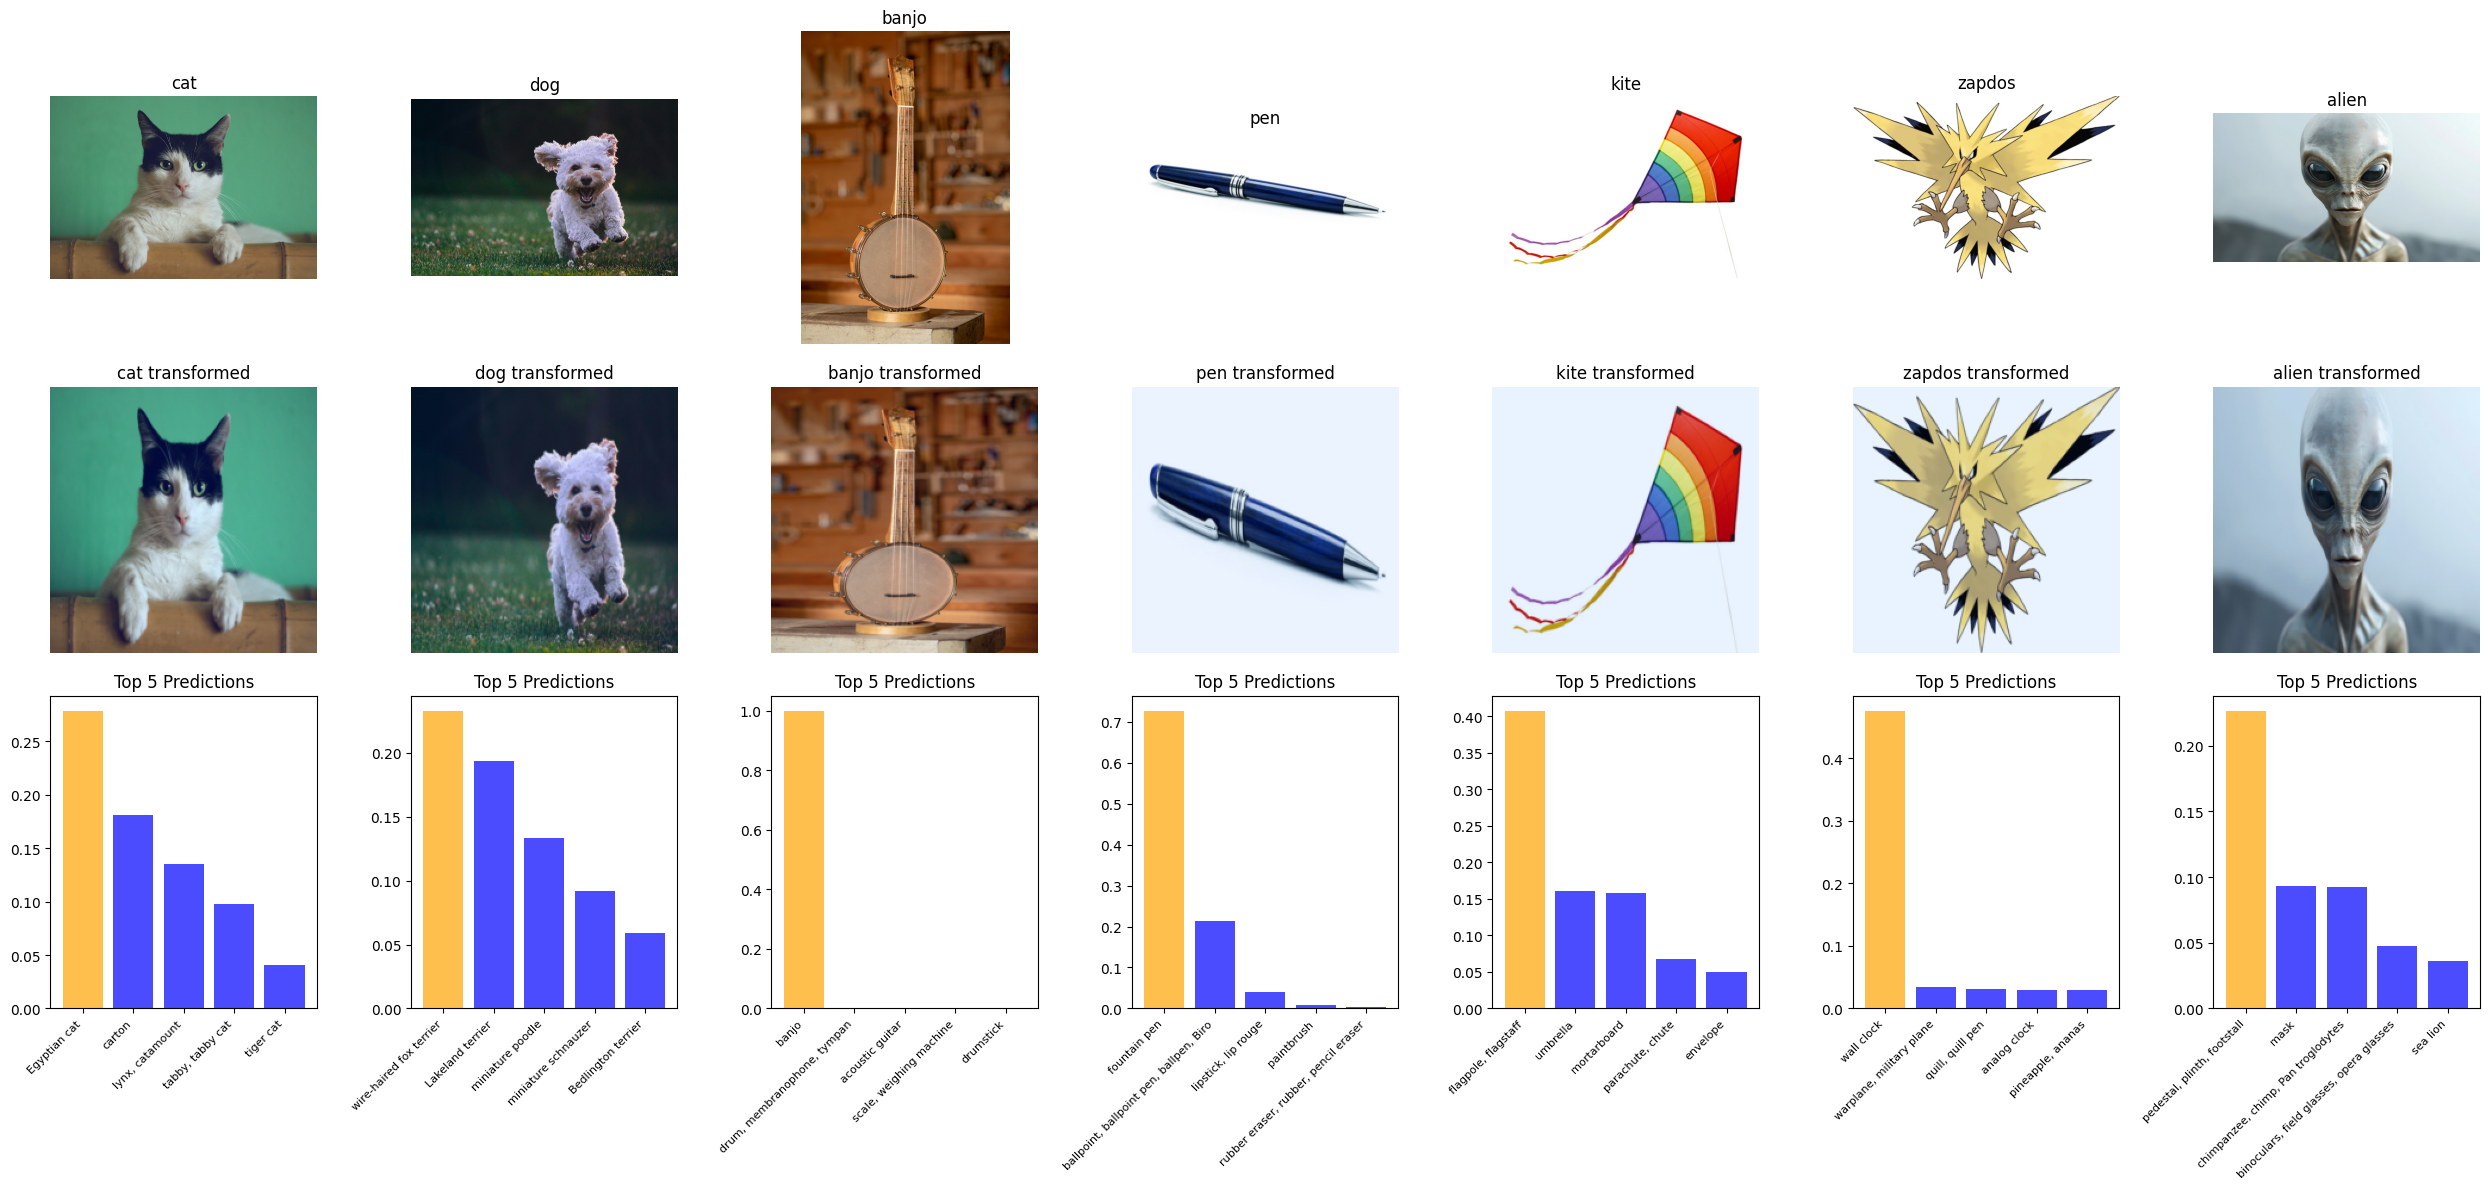

In [25]:
name_images = ["cat.jpg", "dog.jpg", "banjo.jpg", "pen.jpg","kite.jpg","zapdos.jpg","alien.jpg"]
predictions = []

for nameim in name_images:
    img = Image.open("images/"+nameim)
    img = torch.Tensor(np.array(img.resize((224, 224), Image.BILINEAR), dtype=np.float32).transpose((2, 0, 1)) / 255)
    img = (img - mu) / sigma
    img = np.expand_dims(img, 0)
    x = torch.Tensor(img)
    y = vgg16(x) # TODO calcul forward
    y=torch.softmax(y,dim=1)
    y = y.detach().numpy() # transformation en array numpy
    
    # Récupérer les 5 meilleures prédictions
    top5_indices = np.argsort(y[0])[::-1][:5]  # Indices des 5 plus grosses classes
    top5_scores = y[0][top5_indices]          # Scores des 5 classes
    top5_classes = [imagenet_classes[i] for i in top5_indices]  # Noms des classes

    predictions.append((top5_classes, top5_scores))  # Stocker les top 5 classes et scores)

# Afficher les images et leurs prédictions
fig, axes = plt.subplots(3, len(name_images), figsize=(25, 12))  # Plus de hauteur pour l'affichage
for idx, nameim in enumerate(name_images):
    # Affichage de l'image originale
    img = Image.open("images/" + nameim)
    axes[0, idx].imshow(img)
    axes[0, idx].axis('off')
    axes[0, idx].set_title(f"{name_images[idx].split('.')[0]}")

    # Image transformée
    img = torch.Tensor(np.array(img.resize((224, 224), Image.BILINEAR), dtype=np.float32).transpose((2, 0, 1)) / 255)
    img = (img - mu) / sigma
    transformed_img = img.permute(1, 2, 0).numpy()  # Change (C, H, W) -> (H, W, C)
    transformed_img = (transformed_img - transformed_img.min()) / (transformed_img.max() - transformed_img.min())  # Normalisation entre 0 et 1
    axes[1, idx].imshow(transformed_img)
    axes[1, idx].axis('off')
    axes[1, idx].set_title(f"{name_images[idx].split('.')[0] + ' transformed'}")

    # Barres verticales pour les top 5 prédictions

    axes[2, idx].bar(predictions[idx][0], predictions[idx][1], color=['orange','b','b','b','b'], alpha=0.7)
    axes[2, idx].set_xticks(range(len(predictions[idx][0])))  # Position des ticks
    axes[2, idx].set_xticklabels(predictions[idx][0], rotation=45, ha='right', fontsize=8)  # Incliner les labels
    axes[2, idx].set_title("Top 5 Predictions")

    # Annoter les scores sur les barres
    # for i, (score, label) in enumerate(zip(predictions[idx][1], predictions[idx][0])):
    #     axes[2, idx].text(score + 0.01, i, f"{score:.2f}", va='center', fontsize=8)  # Affiche les scores

plt.tight_layout()
plt.show()


In [ ]:
from torchvision.models.feature_extraction import create_feature_extractor, get_graph_node_names
return_nodes = {
    "features.0": "layer1"
}
print(get_graph_node_names(vgg16))
model2 = create_feature_extractor(vgg16, return_nodes=return_nodes)
intermediate_outputs = model2(img)

(['x', 'features.0', 'features.1', 'features.2', 'features.3', 'features.4', 'features.5', 'features.6', 'features.7', 'features.8', 'features.9', 'features.10', 'features.11', 'features.12', 'features.13', 'features.14', 'features.15', 'features.16', 'features.17', 'features.18', 'features.19', 'features.20', 'features.21', 'features.22', 'features.23', 'features.24', 'features.25', 'features.26', 'features.27', 'features.28', 'features.29', 'features.30', 'avgpool', 'flatten', 'classifier.0', 'classifier.1', 'classifier.2', 'classifier.3', 'classifier.4', 'classifier.5', 'classifier.6'], ['x', 'features.0', 'features.1', 'features.2', 'features.3', 'features.4', 'features.5', 'features.6', 'features.7', 'features.8', 'features.9', 'features.10', 'features.11', 'features.12', 'features.13', 'features.14', 'features.15', 'features.16', 'features.17', 'features.18', 'features.19', 'features.20', 'features.21', 'features.22', 'features.23', 'features.24', 'features.25', 'features.26', 'f

TypeError: conv2d() received an invalid combination of arguments - got (numpy.ndarray, Parameter, Parameter, tuple, tuple, tuple, int), but expected one of:
 * (Tensor input, Tensor weight, Tensor bias = None, tuple of ints stride = 1, tuple of ints padding = 0, tuple of ints dilation = 1, int groups = 1)
      didn't match because some of the arguments have invalid types: (!numpy.ndarray!, !Parameter!, !Parameter!, !tuple of (int, int)!, !tuple of (int, int)!, !tuple of (int, int)!, !int!)
 * (Tensor input, Tensor weight, Tensor bias = None, tuple of ints stride = 1, str padding = "valid", tuple of ints dilation = 1, int groups = 1)
      didn't match because some of the arguments have invalid types: (!numpy.ndarray!, !Parameter!, !Parameter!, !tuple of (int, int)!, !tuple of (int, int)!, !tuple of (int, int)!, !int!)


# Partie 2: Transfer Learning avec VGG16 sur 15 Scene

In [ ]:
#!wget https://github.com/cdancette/deep-learning-polytech-tp6-7/raw/master/tp8/15ScenesData.zip
!wget https://github.com/rdfia/rdfia.github.io/raw/master/data/3-a/15ScenesData.zip

!unzip 15ScenesData.zip

In [ ]:
ls 15SceneData/test/bedroom/

In [ ]:
class VGG16relu17:
  pass  # A COMPLÉTER

In [ ]:

PRINT_INTERVAL = 50
CUDA = True

def get_dataset(batch_size, path):

    # This function expands 3 times a gray level image
    # to transform it into an image RGB. Use it with transform.Lambda
    def duplicateChannel(img):
        img = img.convert('L')
        np_img = np.array(img, dtype=np.uint8)
        np_img = np.dstack([np_img, np_img, np_img])
        img = Image.fromarray(np_img, 'RGB')
        return img
    def resizeImage(img):
      return img.resize((224,224), Image.BILINEAR)

    #####################
    ## YOUR CODE HERE  ##
    #####################
    # Add pre-processing
    train_dataset = datasets.ImageFolder(path+'/train',
        transform=transforms.Compose([ # Pre-processing TODO: duplicateChannel(), resizeImage(), toTensor(), Normalize ()
            transforms.ToTensor()
        ]))
    val_dataset = datasets.ImageFolder(path+'/test',
        transform=transforms.Compose([ # Pre-processing TODO
            transforms.ToTensor()
        ]))
    ####################
    ##      END        #
    ####################

    train_loader = torch.utils.data.DataLoader(train_dataset,
                        batch_size=batch_size, shuffle=False, pin_memory=CUDA, num_workers=2)
    val_loader = torch.utils.data.DataLoader(val_dataset,
                        batch_size=batch_size, shuffle=False, pin_memory=CUDA, num_workers=2)

    return train_loader, val_loader

In [ ]:
def extract_features(data, model):
    #####################
    ## YOUR CODE HERE  ##
    #####################
    # init features matrices
    X = None
    y = None
    ####################
    ##      END        #
    ####################

    for i, (input, target) in enumerate(data):
        if i % PRINT_INTERVAL == 0:
            print('Batch {0:03d}/{1:03d}'.format(i, len(data)))
        if CUDA:
            input = input.cuda()
        #####################
        ## YOUR CODE HERE  ##
        #####################
        # Feature extraction à faire
        X = None
        y = None
        ####################
        ##      END        #
        ####################

    return X, y


def main(path="15SceneData", batch_size=8):
    print('Instanciation de VGG16')
    vgg16 = models.vgg16(pretrained=True)

    print('Instanciation de VGG16relu7')
    #####################
    ## YOUR CODE HERE  ##
    #####################
    # Remplacer par le modèle par un réseau tronqué pour faire de la feature extraction
    # On créera une nouvelle classe VGG16relu7 ici
    model = vgg16
    ####################
    ##      END        #
    ####################

    model.eval()
    if CUDA: # si on fait du GPU, passage en CUDA
        cudnn.benchmark = True
        model = model.cuda()

    # On récupère les données
    print('Récupération des données')
    train, test = get_dataset(batch_size, path)

    # Extraction des features
    print('Feature extraction')
    X_train, y_train = extract_features(train, model)
    X_test, y_test = extract_features(test, model)

    #####################
    ## Votre code ici  ##
    #####################
    # Apprentissage et évaluation des SVM à faire
    print('Apprentissage des SVM')
    accuracy = 0
    ####################
    ##      FIN        #
    ####################
    print('Accuracy = %f' % accuracy)


In [ ]:
main("15SceneData", 8)